# Mask to polygons

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_02b import *
import imantics
from simplification.cutil import simplify_coords_vwp
from uuid import uuid4

In [3]:
show_install(True)



```text
=== Software === 
python       : 3.7.4
fastai       : 1.0.59
fastprogress : 0.1.21
torch        : 1.2.0
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-19.0.0-x86_64-i386-64bit
conda env    : fastai_dev
python       : /Users/jack/anaconda3/envs/fastai_dev/bin/python
sys.path     : /Users/jack/git_repos/xview2comp
/Users/jack/anaconda3/envs/fastai_dev/lib/python37.zip
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/lib-dynload

/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/IPython/extensions
/Users/jack/.ipython
../course-v3/nbs/dl2
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



In this notebook, we will:
* Convert a binary mask to a list/table of polygons in it.
* Generate a unique id for each of the polygon.
* For each polygon, crop out the part of the original image that lies underneath the polygon -- which we call the *polygon image*.
* Save each polygon image in an .png file named after its polygon's unique id.

In [4]:
SOURCE = Path('data/train/')
SOURCE.ls()

[PosixPath('data/train/train.tar.gz'),
 PosixPath('data/train/images'),
 PosixPath('data/train/damagemasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/binarymasks')]

In [5]:
npreimgs = pre_img_fpaths(get_image_files(SOURCE/'images'))
npreimgs[:3]

[PosixPath('data/train/images/hurricane-harvey_00000015_pre_disaster.png'),
 PosixPath('data/train/images/hurricane-harvey_00000228_pre_disaster.png'),
 PosixPath('data/train/images/hurricane-michael_00000261_pre_disaster.png')]

### Grab a single sample  

Grab a single sample from the training set.  Get the paths to the pre-disaster image, the post-disaster image, the binary mask (which is made from the pre-disaster image's annotations).

In [6]:
idx = 367

In [7]:
npreimg = npreimgs[idx]
nposimg = pre2post_fpath(npreimgs[idx])
nbmask = img2bmask_fpath(npreimg)

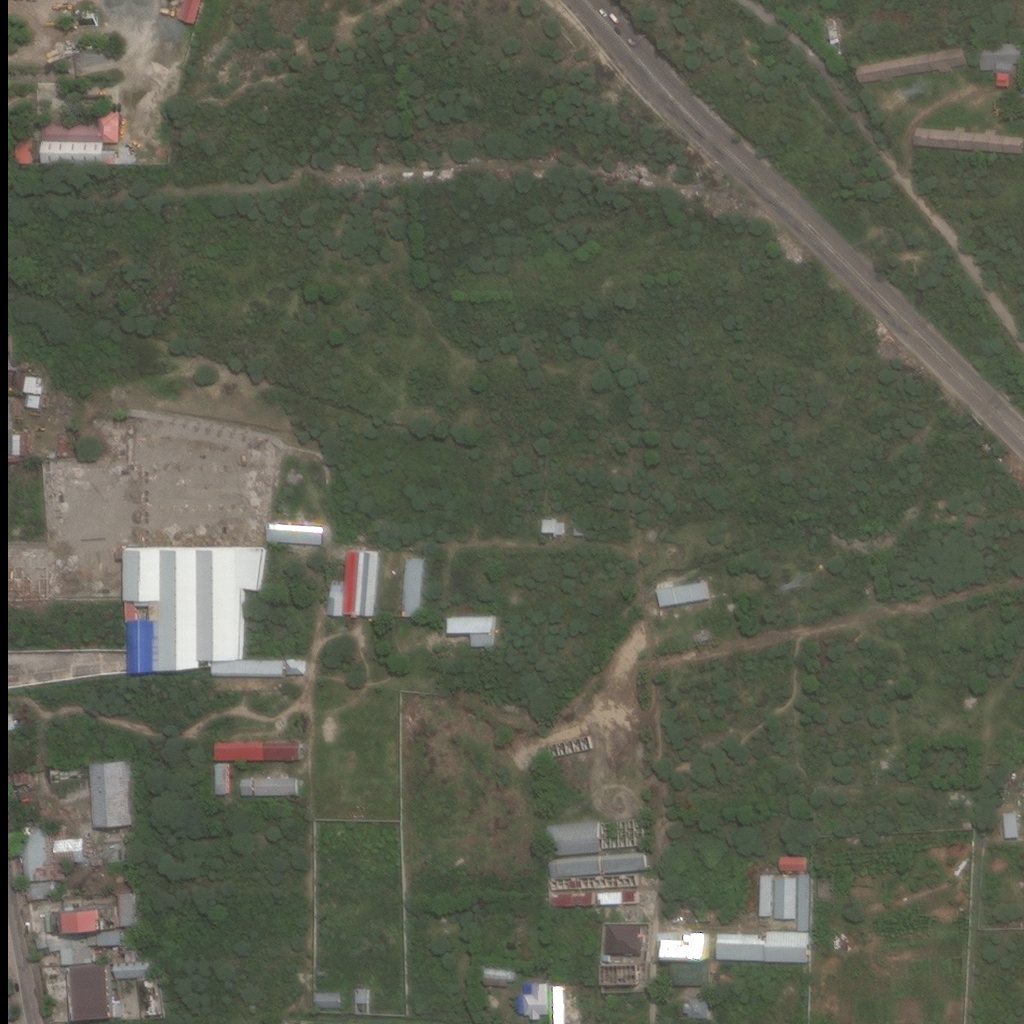

In [8]:
open_image(npreimg)

In [9]:
bmask = open_mask(nbmask)

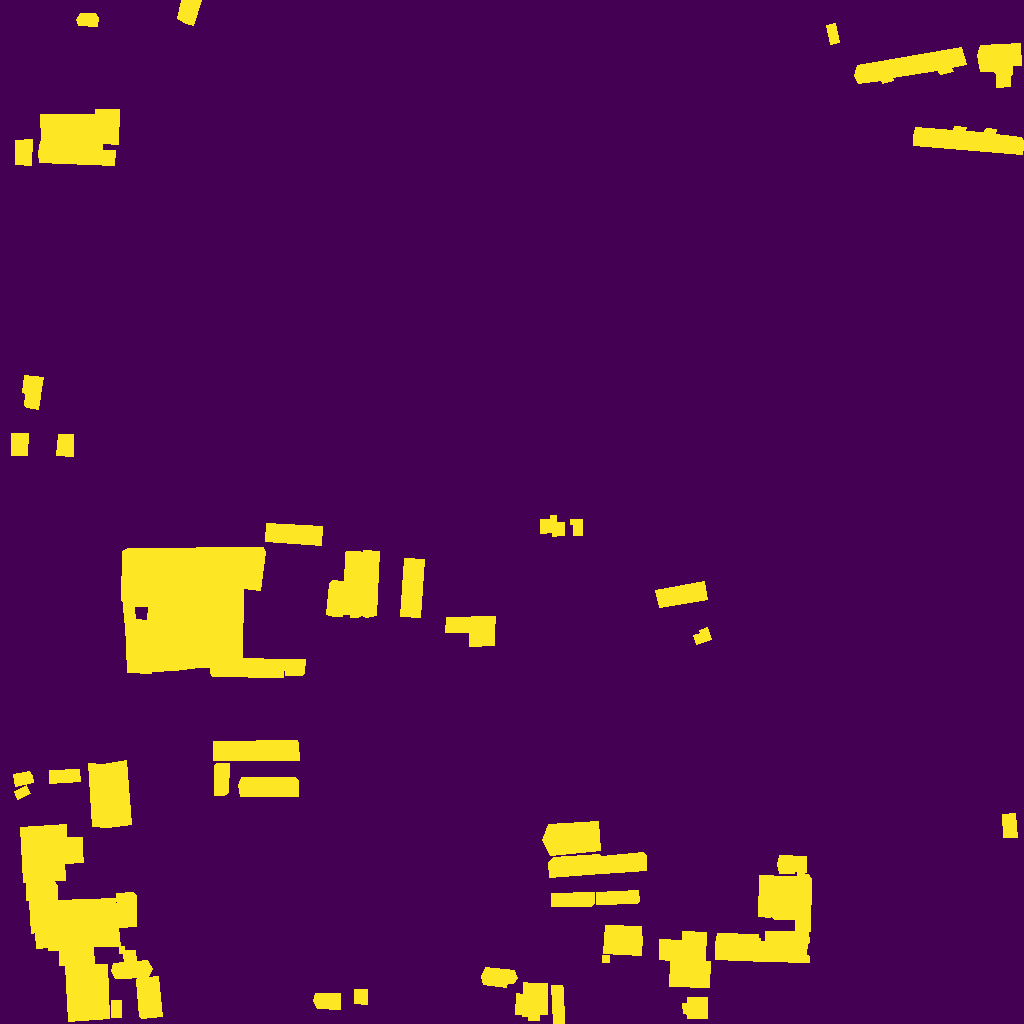

In [10]:
bmask

#### Convert binary mask to polygon

This was already outlined in *01_load_data.ipynb*. Here, the procedures defined there are refactored into functions.

In [11]:
#export
def bmask2polys(mask):
    '''
    Convert mask to polys.
    mask: 2d numpy.ndarray 
    ps: np.array of np.arrays, containing all polygons', 
        their vertices' (x, y) coordinates.
    '''
    sz = mask.shape[0]
    ps = imantics.Mask(mask).polygons()
    ps = (p.reshape(-1, 2) for p in ps)
    ps = (simplify_coords_vwp(p, .3).astype(np.int32) for p in ps)
    return sz, np.array([np.concatenate((p, p[0][None,...])) for p in ps])

In [12]:
sz, polys = bmask2polys(bmask.data[0])

Convert the obtained polygons back to a binary mask to see if its' something close to the original binary mask.  

In [13]:
#export
def polys2bmask(polys, sz):
    '''
    Convert polygons to binary mask.
    polys: np.array of np.arrays, containing all polygons', 
        their vertices' (x, y) coordinates.
    mask: 2d numpy.ndarray
    '''
    mask = np.zeros((sz, sz), dtype=np.uint8)
    cv2.fillPoly(mask, polys, (1,));
    return mask

In [14]:
bmask_recon = polys2bmask(polys, sz)

Convert `np.array` binary mask to fastai's `ImageSegment` object.

In [15]:
bmask_recon = ImageSegment(tensor(bmask_recon[None,...]))

In [16]:
np.allclose(bmask_recon.data, bmask.data)

True

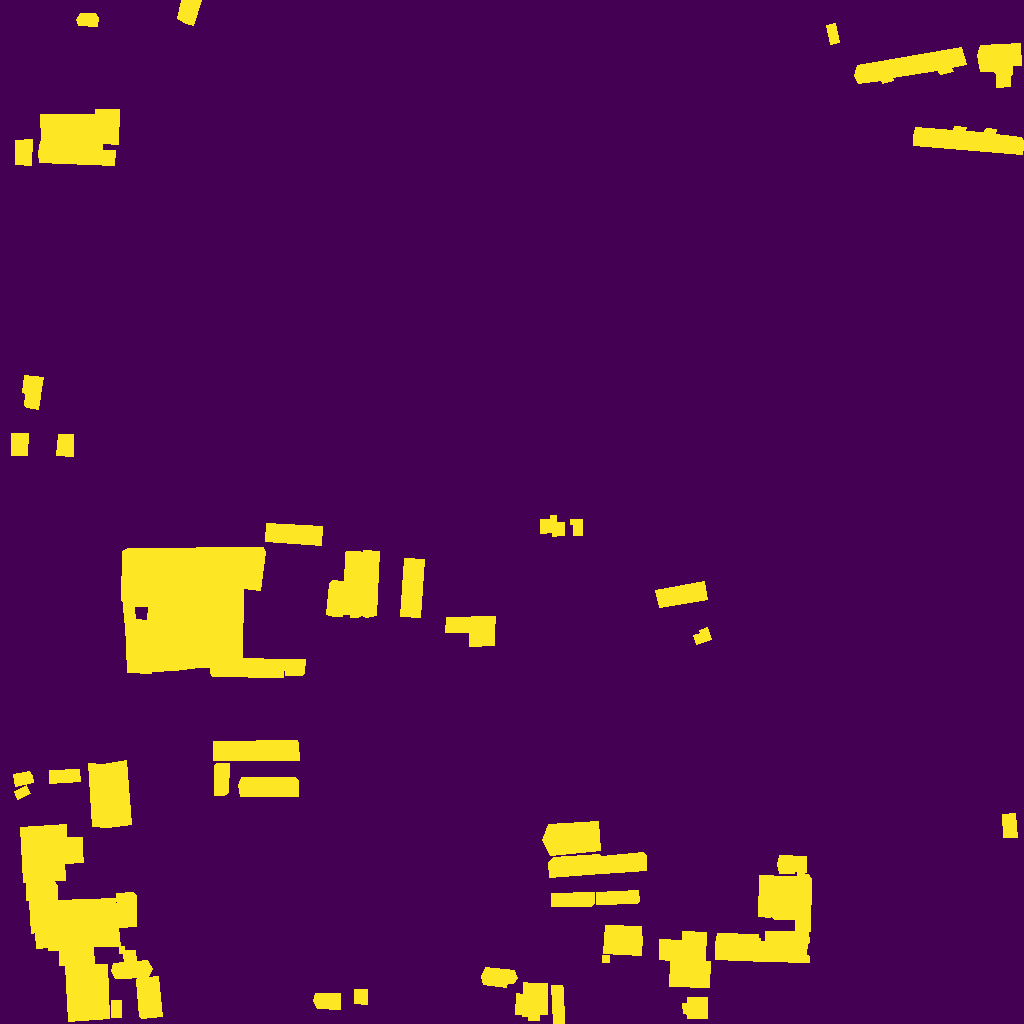

In [17]:
bmask_recon

### Generate an id for each polygon

In [21]:
uid = uuid4()
uid

UUID('fa85b951-5220-4661-ac44-d42f3cf3d7d8')

In [22]:
str(uid)

'fa85b951-5220-4661-ac44-d42f3cf3d7d8'

In [23]:
uids = np.array([str(uuid4()) for _ in polys])

In [24]:
df_polys = pd.DataFrame({'uid':uids, 'polygon':polys})

We now have a table listing the polygons and their id:

In [25]:
df_polys.head()

,uid,polygon
0,94c3bdc0-ae2d-4d43-b713-f88dc9eb03b7,"[[111, 1000], [111, 1017], [121, 1017], [121, ..."
1,62356633-bb65-4643-a869-a49a86874faf,"[[687, 997], [687, 1002], [686, 1003], [682, 1..."
2,e3172bcd-9a65-44a5-8043-7fa51006fc5b,"[[315, 993], [315, 994], [314, 995], [314, 998..."
3,f4028750-bbe1-4068-a0e8-030e2385ca31,"[[354, 989], [354, 1003], [360, 1003], [361, 1..."
4,ae4f1870-7923-4476-96ac-346a0508155e,"[[551, 985], [551, 994], [552, 995], [552, 101..."


### Get *polygon images*

The rectangular part of the original image in which a polygon just fits is called a *polygon* image.  In this section, we look at how to get a polygon image from a polygon and the image in which it sits.

In [26]:
polygon = df_polys.iloc[13].polygon
polygon

array([[779, 855],
       [779, 857],
       [778, 858],
       [778, 861],
       ...,
       [806, 856],
       [793, 856],
       [792, 855],
       [779, 855]], dtype=int32)

In [27]:
posimg = open_image(nposimg)

In [28]:
#export
def crop_by_polygon(img:Image, polygon:np.ndarray, scale_pct=.5):
    '''
    Crop image by polygon
    img: image in which polygon lies.
    polygon: numpy array of (x, y) coordinates of vertices of polygon.
    '''
    width, height = img.size
    xs, ys = zip(*polygon)
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    dx, dy = xmax - xmin, ymax - ymin
    ddx, ddy = scale_pct * dx, scale_pct * dy
    xmin, xmax = int(np.floor(xmin - ddx)), int(np.ceil(xmax + ddx))
    ymin, ymax = int(np.floor(ymin - ddy)), int(np.ceil(ymax + ddy))
    xmin, xmax = max(xmin, 0), min(xmax, width)
    ymin, ymax = max(ymin, 0), min(ymax, height)
    return Image(img.data[:,ymin:ymax,xmin:xmax])

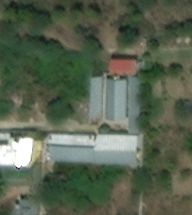

In [29]:
crop_by_polygon(posimg, polygon)

# -fin

In [30]:
! python notebook2script.py 02c_bmask_to_polygons.ipynb

Converted 02c_bmask_to_polygons.ipynb to xview2comp/nb_02c.py
